# Demo for land price prediction

This notebook will demonstrate how our land price predictor works.

This land price prediction system is composed of

- SegFormer <= We downloaded pretrained segformer-b2 and finetuned it with [LoveDA](https://github.com/Junjue-Wang/LoveDA) dataset
- LandNet <= We devised an architecture named `LandNet` which utilizes both satellite image and segmentation map for land price prediction

⚠️ Please **manually** download model checkpoint for LandNet from [this URL](https://drive.google.com/file/d/1OzzCMBOssCAJwbXKU9g6y4iB07HmX-Nu/view?usp=sharing) and upload to Colab before executing below cells ⚠️

## Preparation

Check if this notebook is running on Google Colaboratory

In [1]:
# whether this notebook is on Google Colaboratory
try:
    import google.colab
    ON_COLAB = True
except:
    ON_COLAB = False
else:
    pass
    %pip install transformers

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as nnF
import torchvision.transforms.functional as trF
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

Check if GPU is available

In [2]:
if not torch.cuda.is_available():
    RuntimeError("GPU is not available. Please change runtime to GPU from \"Runtime\" tab -> \"Change runtime type\".")

## Load models

Model configurations

In [3]:
id2label = {
    0: "Ignore",
    1: "Background",
    2: "Building",
    3: "Road",
    4: "Water",
    5: "Barren",
    6: "Forest",
    7: "Agricultural"
}
label2id = { v: k for k, v in id2label.items() }

Load finetuned SegFormer

In [ ]:
feature_extractor = SegformerFeatureExtractor()
segformer = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name_or_path="wu-pr-gw/segformer-b2-finetuned-with-LoveDA",
    id2label=id2label,
    label2id=label2id,
).to("cuda")

Load pretrained LandNet

In [5]:
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights

class FeatureMapCompresser(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.3)
        # (height_of_feature_map)x(width_of_feature_map)x(num_filter_for_each_channel)
        self.feat_wise_fc_to_128 = nn.Linear(in_features=29*29*2, out_features=128)
        self.feat_wise_fc_last = nn.Linear(in_features=128, out_features=32)

    def forward(self, x):
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.feat_wise_fc_to_128(x)
        x = self.feat_wise_fc_last(x)
        return x

class EfficientNetBasedFeatureExtractor(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        whole_effnet = efficientnet_v2_m(
            weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1
        )
        # omit the last classification layer
        self.effnet_without_classifier = nn.Sequential(
            whole_effnet.features,
            whole_effnet.avgpool,
        )
        self.fc_to_512 = nn.Linear(in_features=1280, out_features=512)
        self.fc_to_256 = nn.Linear(in_features=512, out_features=256)

    def forward(self, x):
        x = self.effnet_without_classifier(x)  # size of x == torch.Size([BATCH, 1280, 1, 1])
        x = torch.squeeze(x)
        x = self.fc_to_512(x)
        x = self.fc_to_256(x)
        return x

class LandNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.effnet_feat_extractor = EfficientNetBasedFeatureExtractor()
        self.conv_feat_extractor = nn.Sequential(
            nn.Conv2d(
                in_channels=6, # number of meaningful class in segmentation maps
                out_channels=12,
                kernel_size=4,
                groups=6  # MUST be the same as `in_channels`. This works as depth-wise convolution
                # `out_channels`/`in_channels` (= 2) dedicated filters are applied to each channel in the input
            ),
            nn.MaxPool2d(kernel_size=16),  # each side of feature map becomes 1/16 the length of previous one
        )
        self.feat_compresser_for_build = FeatureMapCompresser()
        self.feat_compresser_for_road = FeatureMapCompresser()
        self.feat_compresser_for_water = FeatureMapCompresser()
        self.feat_compresser_for_barren = FeatureMapCompresser()
        self.feat_compresser_for_forest = FeatureMapCompresser()
        self.feat_compresser_for_agri = FeatureMapCompresser()

        self.trailing_fc_to_256 = nn.Linear(in_features=256+32*6, out_features=256)
        self.trailing_fc_to_64 = nn.Linear(in_features=256, out_features=64)
        self.last_fc = nn.Linear(in_features=64, out_features=1)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, image, segmap):
        feat_image = self.effnet_feat_extractor(image)

        y = self.conv_feat_extractor(segmap)
        feat_build = self.feat_compresser_for_build(y[:, :2, ...])
        feat_road = self.feat_compresser_for_road(y[:, 2:4, ...])
        feat_water = self.feat_compresser_for_water(y[:, 4:6, ...])
        feat_barren = self.feat_compresser_for_barren(y[:, 6:8, ...])
        feat_forest = self.feat_compresser_for_forest(y[:, 8:10, ...])
        feat_agri = self.feat_compresser_for_agri(y[:, 10:12, ...])\

        feat_concat = torch.cat(
            # IMPORTANT: since the size of batch is 1 in this notebook, x.squeeze() in
            # EfficientNetBasedFeatureExtractor.forward() erases the first dimension (batch_size).
            # So we should unsqueeze it here
            tensors=[feat_image.unsqueeze(0), feat_build, feat_road, feat_water, feat_barren, feat_forest, feat_agri],
            dim=1
        )
        overall_feat = self.trailing_fc_to_256(feat_concat)
        overall_feat = self.dropout(overall_feat)
        overall_feat = self.trailing_fc_to_64(overall_feat)
        pred_value = self.last_fc(overall_feat)

        return pred_value

In [ ]:
landnet = LandNet()
landnet.load_state_dict(torch.load("landnet.pth"))
landnet.to("cuda")

## Predict land price

define utility function

In [7]:
def predict_land_price(img_filename: str):
    
    # make a segmentation map using segformer
    image = Image.open(img_filename).convert(mode="RGB")
    segformer_input = feature_extractor(images=image, return_tensors="pt").to("cuda")
    segmentation_map = feature_extractor.post_process_semantic_segmentation(
        outputs=segformer(**segformer_input),
        target_sizes=[(480, 480)],
    )[0]
    
    # visualize the segmentation map
    SEGMAP_CLASS_NUM = 8
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.suptitle("Visualization of the segmentation map")
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    axmask = ax[1].matshow(
        segmentation_map.cpu().numpy().astype(np.uint8),
        cmap=plt.get_cmap('Set1', SEGMAP_CLASS_NUM)  # https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
    )
    ax[1].set_title("Segmentation Map")
    cbar = fig.colorbar(axmask, ax=ax)
    cbar.set_ticks(
        ticks=list(id2label.keys()),
        labels=list(id2label.values()),
    )
    plt.show()
    
    # convert image to Tensor
    image = trF.to_tensor(image)
    image = trF.resize(
        img=image,
        size=(480, 480),
        antialias=True,
    ).float()
    
    # convert the segmentation map into one-hot format
    segmentation_map_onehot = nnF.one_hot(
        segmentation_map.unsqueeze(0).long(), SEGMAP_CLASS_NUM
    ).transpose(0, 3).squeeze().float()
    # segmentation map is now torch.Size([SEGMAP_CLASS_NUM, 480, 480])
    
    # unsqueeze image & segmentation map, in order to convert them into a batch
    image = image.unsqueeze(0)
    segmap = segmentation_map_onehot.unsqueeze(0)
    
    # move the image and segmap to GPU
    image, segmap = image.to("cuda"), segmap.to("cuda")
    
    # estimate the land price. first 2 channels of segmap (Ignore, Background) are not used
    landprice = landnet(image, segmap[:, 2:, ...])[0]
    print("predicted price: ", landprice.cpu().item())

Let's predict land price!

Upload PNG file to Colab, and run `predict_land_price`

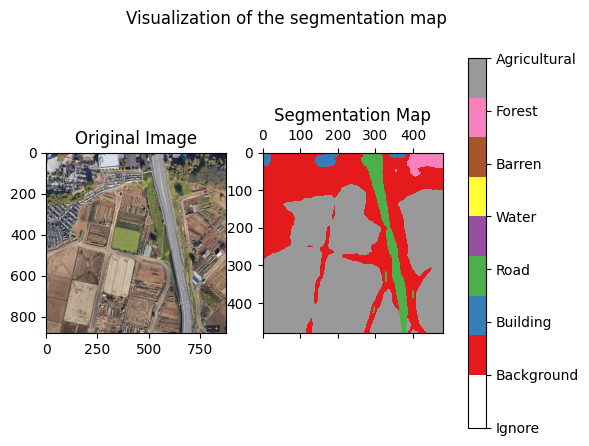

predicted price:  67808.6171875


In [8]:
IMG_FILENAME = "YOUR_IMAGE_FILENAME"

predict_land_price(img_filename=IMG_FILENAME)